In [1]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [2]:
threshold_event_magnitude = 0.5

In [3]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [5]:
def plot_model_evolution(Loss,b,c,R,U,V,W):
    fig,ax = plt.subplots(nrows=7,figsize=(15,18),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(R[:,0],label='R1')
    ax[3].plot(R[:,1],label='R2')
    ax[3].plot(R[:,2],label='R3')
    ax[4].plot(V[:,0,0],label='V11')
    ax[4].plot(V[:,0,1],label='V12')
    ax[4].plot(V[:,0,2],label='V13')
    ax[4].plot(V[:,1,0],label='V21')
    ax[4].plot(V[:,1,1],label='V22')
    ax[4].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[5].plot(U[:,i,j],label=ulabels[i][j])
            ax[6].plot(W[:,i,j],label=wlabels[i][j])
            
    for i in range(7):
        ax[i].legend(fontsize=8)
    plt.show() 

In [6]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [7]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [8]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [43]:
def initialization(Nit):

    U = np.zeros((Nit,3,3))
    W = np.zeros((Nit,3,3))
    R = np.zeros((Nit,3))
    b = np.zeros((Nit,3))
    V = np.zeros((Nit,2,3))
    c = np.zeros((Nit,2))

    dR = np.zeros((Nit,3))
    dU = np.zeros((Nit,3,3))
    dW = np.zeros((Nit,3,3))
    db = np.zeros((Nit,3))
    dV = np.zeros((Nit,2,3))
    dc = np.zeros((Nit,2))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(3):
        for j in range(3):
            U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
            W[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        b[0,i]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        R[0,i]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
    for i in range(2):
        for k in range(3):
            V[0,i,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        c[0,i] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom    

    Loss = np.zeros(Nit)

    return U,W,R,b,V,c,dR,dU,dW,db,dV,dc,yhat,Loss

In [10]:
def prediction(b,c,R,U,V,W,x):
    N = len(x)
    a = np.zeros((N,3))
    h = np.zeros((N,3))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0] = b + np.dot(U,x[0])
    h[0] = np.tanh(a[0])
    o[0] = c + np.dot(V,h[0])
    for t in range(0,N):
        a[t] = b + np.dot(W,h[t-1])+np.dot(U,x[t])+np.dot(R,y[t-1,0])
        h[t] = np.tanh(a[t])
        o[t] = c + np.dot(V,h[t])
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(h,o,V,W,x,y,yhat):
    N = len(x)
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,3))
    dh[-1] = np.dot(V.transpose(),do[-1])
    for t in range(N-2,-1,-1):
        diag = np.diag(np.array([1-h[t+1,0]**2,1-h[t+1,1]**2,1-h[t+1,2]**2]))
        dh[t] = np.dot(np.dot(W.transpose(),diag),dh[t+1])+np.dot(V.transpose(),do[t])

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros(3)
    dV = np.zeros((2,3))
    dR = np.zeros(3)
    dW = np.zeros((3,3))
    dU = np.zeros((3,3))
    for i in range(3):
        for t in range(N):
            db[i] += (1-h[t,i]**2)*dh[t,i]
    
    for t in range(N):
        dV[0,0] += do[t,0]*h[t,0]
        dV[1,0] += do[t,1]*h[t,0]
        dV[0,1] += do[t,0]*h[t,1]
        dV[1,1] += do[t,1]*h[t,1]
        dV[0,2] += do[t,0]*h[t,2]
        dV[1,2] += do[t,1]*h[t,2]

    for t in range(1,N):
        mat = np.zeros((3,3))
        mat2 = np.zeros((3,3))
        mat3 = np.zeros(3)
        for i in range(3):
            for j in range(3):
                mat[i,j] = dh[t,i] * h[t-1,j]
                mat2[i,j] = dh[t,i] * x[t,j]
            mat3[i] = dh[t,i]*y[t,0]
                
        dW += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat)
        dU += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat2)
        dR += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat3)
    return db,dc,do,dR,dU,dV,dW

In [11]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [52]:
#data acquisition
N = len(data)
x = [[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()

x = mapx(x)

N = len(x)

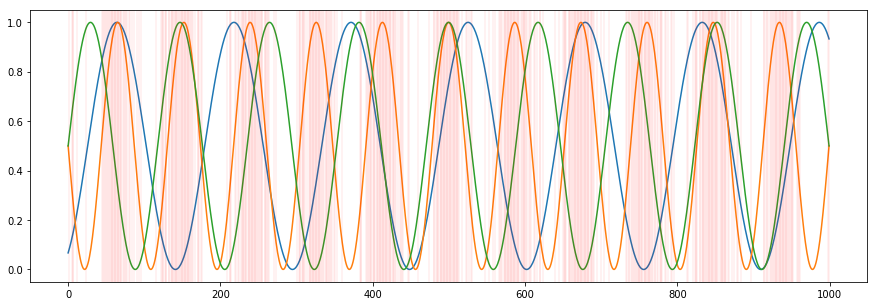

In [59]:
#fake data
N = 1000
x = np.zeros((N,3))
y = np.zeros((N,2))
x[:,0] = 5*(np.sin(np.linspace(0,13*np.pi,N)-np.pi/3)+1)/2
x[:,1] = -(np.sin(np.linspace(0,23*np.pi,N))+1)/2
x[:,2] = 100*(np.sin(np.linspace(0,17*np.pi,N))+1)/2

x = mapx(x)
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
xx = []
yy = []
for i in range(N):
    if np.random.randint(100)/100 < x[i,1]:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()

### RNN-Model, fig. 10.10: h_t depends on observation y_t-1

It performs best if events happen right after each other on a consistent basis. If this is the case, the model always misses the first event of a string and hence too much emphasis is put on matrix R. 

The real data set isn't nicely estimated even though the final product seems nuanced.

In [60]:
Nit = 1000
eps = 0.001
Late_R = False
NR = 100

U,W,R,b,V,c,dR,dU,dW,db,dV,dc,yhat,Loss = initialization(Nit)

if Late_R:
    if NR>=Nit:
        R = np.zeros((Nit,3))
    else:
        R[NR] = R[0]
        R[0] = np.zeros(3)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],R[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],do,dR[k],dU[k],dV[k],dW[k] = gradients(h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]
        if not Late_R or (Late_R and k>NR):
            R[k+1] = R[k] + eps*dR[k]

0 389.603829603
1 364.506239395
2 349.452227452
3 338.543387686
4 330.067374184
5 323.208581923
6 317.490802176
7 312.607966324
8 308.351852786
9 304.575141228
10 301.170531822
11 298.05815147
12 295.177580662
13 292.482598694
14 289.937596606
15 287.515051603
16 285.193701726
17 282.957199882
18 280.793108751
19 278.69214685
20 276.647624329
21 274.655022651
22 272.711680151
23 270.816548899
24 268.969990183
25 267.173578379
26 265.429887524
27 263.742242521
28 262.114427335
29 260.550354758
30 259.053714297
31 257.627624176
32 256.274318293
33 254.994898084
34 253.789172957
35 252.655602613
36 251.591342675
37 250.592383846
38 249.653766299
39 248.769845981
40 247.934587945
41 247.141863077
42 246.385727487
43 245.660667631
44 244.961798273
45 244.285004437
46 243.627022672
47 242.985461179
48 242.358762798
49 241.74611903
50 241.14734691
51 240.562742953
52 239.992929144
53 239.438705013
54 238.90091715
55 238.380353896
56 237.877668823
57 237.393332859
58 236.927611965
59 236.48056

464 210.600493971
465 210.589519971
466 210.578581234
467 210.567679454
468 210.55681618
469 210.545992816
470 210.535210636
471 210.524470782
472 210.513774275
473 210.503122018
474 210.492514803
475 210.481953315
476 210.47143814
477 210.460969771
478 210.45054861
479 210.440174976
480 210.429849109
481 210.419571177
482 210.409341278
483 210.399159447
484 210.389025659
485 210.378939834
486 210.368901841
487 210.358911502
488 210.348968596
489 210.339072863
490 210.329224007
491 210.319421699
492 210.30966558
493 210.299955264
494 210.290290345
495 210.280670391
496 210.271094954
497 210.26156357
498 210.25207576
499 210.242631035
500 210.233228894
501 210.22386883
502 210.214550329
503 210.205272871
504 210.196035936
505 210.186838999
506 210.177681537
507 210.168563028
508 210.159482951
509 210.150440787
510 210.141436024
511 210.132468152
512 210.12353667
513 210.11464108
514 210.105780893
515 210.096955628
516 210.088164813
517 210.079407982
518 210.070684682
519 210.061994467
5

923 207.670436945
924 207.664317941
925 207.658200279
926 207.652084288
927 207.645970297
928 207.639858636
929 207.633749634
930 207.62764362
931 207.621540921
932 207.615441867
933 207.609346782
934 207.603255991
935 207.597169818
936 207.591088584
937 207.585012608
938 207.578942207
939 207.572877694
940 207.566819383
941 207.56076758
942 207.554722592
943 207.548684719
944 207.542654262
945 207.536631513
946 207.530616765
947 207.524610304
948 207.518612412
949 207.512623369
950 207.506643447
951 207.500672917
952 207.494712043
953 207.488761086
954 207.482820302
955 207.476889939
956 207.470970245
957 207.465061459
958 207.459163817
959 207.45327755
960 207.447402882
961 207.441540033
962 207.435689218
963 207.429850647
964 207.424024523
965 207.418211046
966 207.412410408
967 207.406622798
968 207.400848399
969 207.395087387
970 207.389339936
971 207.38360621
972 207.377886373
973 207.372180579
974 207.366488979
975 207.360811718
976 207.355148936
977 207.349500769
978 207.343867

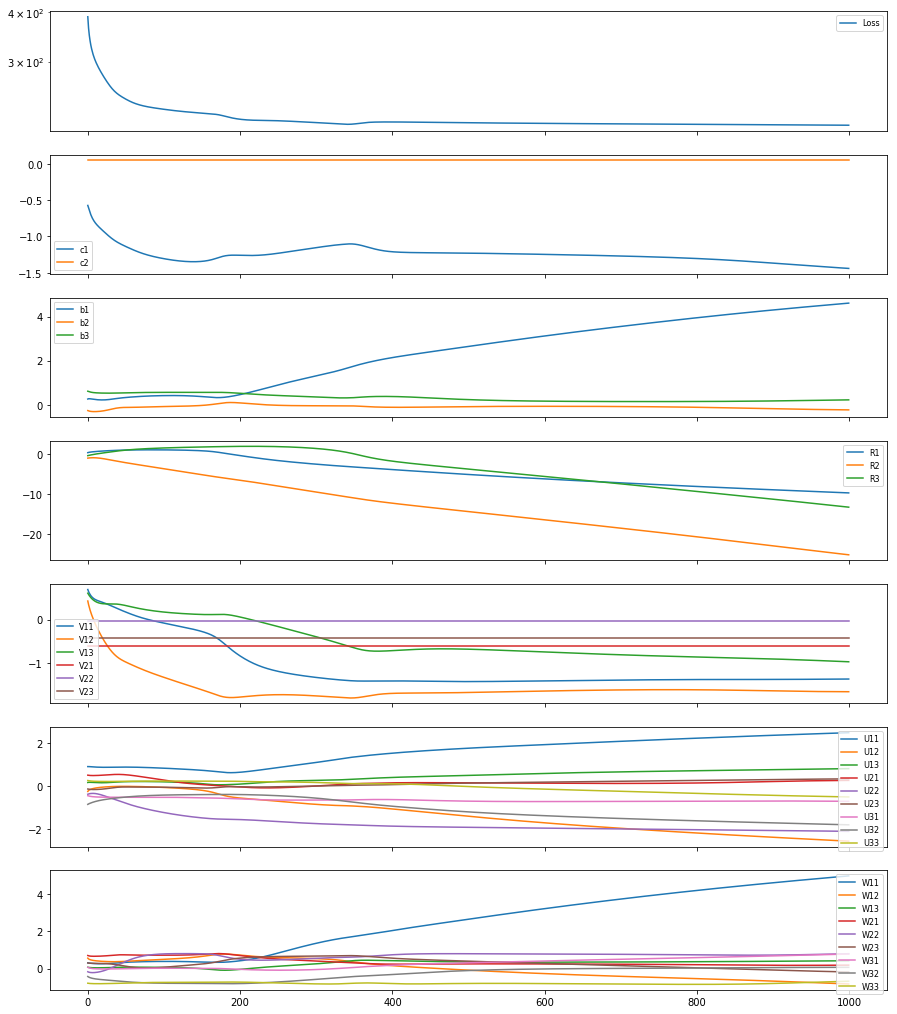

In [61]:
plot_model_evolution(Loss,b,c,R,U,V,W)

In [62]:
_,_,pred = prediction(b[-1],c[-1],R[-1],U[-1],V[-1],W[-1],x)

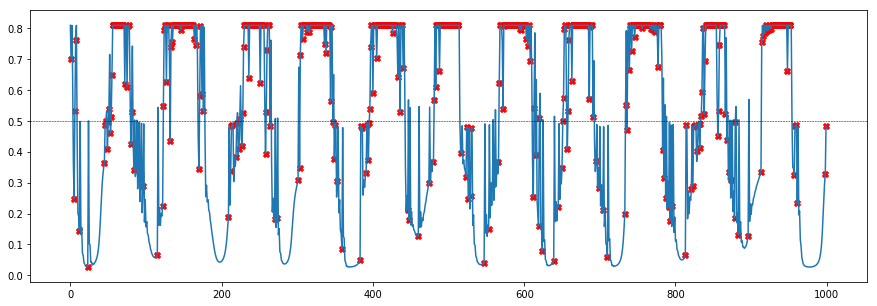

True Positives:   371
False Positives:  119
False Negatives:  106
True Negatives:   404


In [64]:
q = 0.5

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.show()

C = Confusionmatrix(y,pred,q)